# SED with $L_{acc}$ and $T_{max}$

Trying out new parameter tradeoffs. Started 23 August 2021.

### Imports

In [76]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct29_copy import *
from fu_ori_classes_oct29_copy import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import scipy.signal as signal


import emcee
import corner
import time
%matplotlib inline 

In [77]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

In [78]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [79]:
def getDataArrayMOD(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(0,len(fulltxt), 2):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [80]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [81]:
direcToArray('/Users/tonyrodriguez/Documents/Docs/2019 Summer/Stellar Atmospheres/')

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

### Interpolating grid of stellar atmospheres on same grid as data:

First, reading in data...

In [82]:
txt_in = getDataArrayMOD('gaia_out.csv')
WAV_DAT = txt_in[:,0]
FLUX_DAT = txt_in[:,1]
FLUX_DAT_ERR = -0.01*FLUX_DAT

In [83]:
import spectres

In [84]:
def getInterpTable(st_atm_table, waves_data):
    out_table = dict()
    for key in ATM_TABLE:
        wav, lum = ATM_TABLE[key]
#         interp_func = interpolate.interp1d(wav, lum, kind = 'linear')
#         out_table[key] = waves_data, interp_func(waves_data)
        out_table[key] =  waves_data, spectres.spectres(waves_data, wav, lum)
    return out_table

In [85]:
WAVES_DATA_LOGGED = WAV_DAT

In [86]:
len(WAVES_DATA_LOGGED)

595

In [87]:
WAVES_DATA = 1e4*(10**WAVES_DATA_LOGGED)

In [88]:
ATM_TABLE_INTERP = getInterpTable(ATM_TABLE, WAVES_DATA)

In [89]:
ATM_TABLE_INTERP.keys()

dict_keys([(2000, 1.5), (2000, 4.0), (2100, 1.5), (2100, 4.0), (2200, 1.5), (2200, 4.0), (2300, 1.5), (2300, 4.0), (2400, 1.5), (2400, 4.0), (2500, 1.5), (2500, 4.0), (2600, 1.5), (2600, 4.0), (2700, 1.5), (2700, 4.0), (2800, 1.5), (2800, 4.0), (2900, 1.5), (2900, 4.0), (3000, 1.5), (3000, 4.0), (3100, 1.5), (3100, 4.0), (3200, 1.5), (3200, 4.0), (3300, 1.5), (3300, 4.0), (3400, 1.5), (3400, 4.0), (3500, 1.5), (3500, 4.0), (3600, 1.5), (3600, 4.0), (3700, 1.5), (3700, 4.0), (3800, 1.5), (3800, 4.0), (3900, 1.5), (3900, 4.0), (4000, 1.5), (4000, 4.0), (4100, 1.5), (4100, 4.0), (4200, 1.5), (4200, 4.0), (4300, 1.5), (4300, 4.0), (4400, 1.5), (4400, 4.0), (4500, 1.5), (4500, 4.0), (4600, 1.5), (4600, 4.0), (4700, 1.5), (4700, 4.0), (4800, 1.5), (4800, 4.0), (4900, 1.5), (4900, 4.0), (5000, 1.5), (5000, 4.0), (5100, 1.5), (5100, 4.0), (5200, 1.5), (5200, 4.0), (5300, 1.5), (5300, 4.0), (5400, 1.5), (5400, 4.0), (5500, 1.5), (5500, 4.0), (5600, 1.5), (5600, 4.0), (5700, 1.5), (5700, 4.0), (

In [90]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = 0
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, dist, grav, direc, a_v, atm_table, pl_index):
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table, pl_index)
        fuori.setAnnuliValues(10000, 2000, 200, 2*R_STAR)
        fuori.createAnnuliFromDirec(grav, direc, 'stellar atmospheres')
        fuori.createModelSpectrum('stellar atmospheres', False)
        self.fuori = fuori

### Making an instance of the class

In [91]:
PARAMS = [5.3, 7000, 3.63]
CONST = (3/(8*np.pi*SIG_SB))*(1/7)*(36/49)**3

In [92]:
CONST

119.25607087833384

In [93]:
CONST

119.25607087833384

In [94]:
L_ACC = PARAMS[0]*L_SUN

T_MAX = PARAMS[1]
R_STAR = (2*L_ACC*CONST/T_MAX**4)**0.5
M_STAR = 0.5*M_SUN
R_OUTER = 100 * R_STAR
M_DOT = 2*L_ACC*R_STAR/ G / M_STAR
A_V = PARAMS[2]
INC = np.degrees(np.arccos(0.1))
DIST = 1.27e3*3.08567758128e18
DIREC = '/Users/tonyrodriguez/Documents/Docs/2019 Summer/Stellar Atmospheres/'

In [95]:
def getRadius(lacc, tmax):
    return (2*lacc*CONST/tmax**4)**0.5

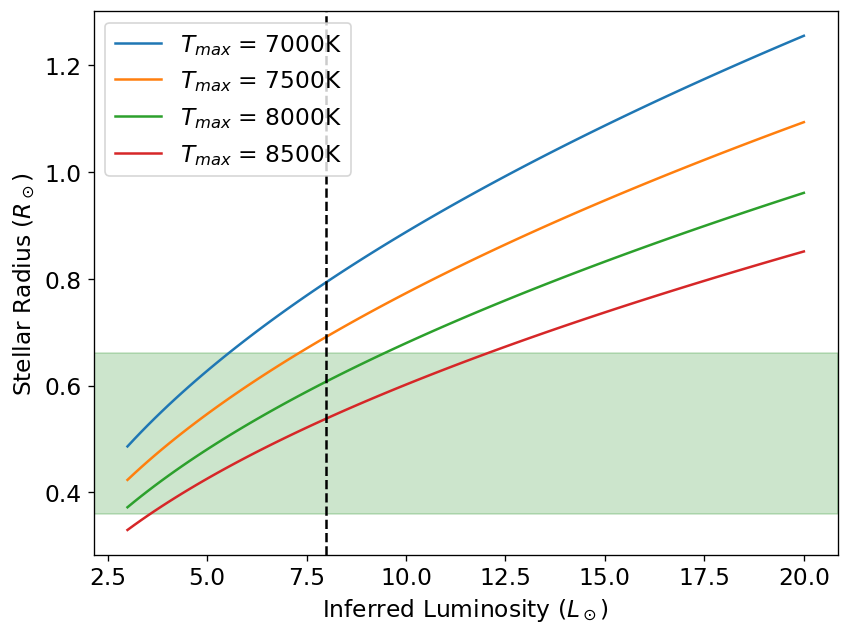

In [96]:
fig=plt.figure(figsize=(8, 6), dpi= 120)
plt.rcParams.update({'font.size': 14})
lacc_grid = np.linspace(3,20, 100)*L_SUN
tmax_grid = np.linspace(7000, 8000, 100)
plt.plot(lacc_grid/L_SUN, getRadius(lacc_grid, 7000)/R_SUN, label=r'$T_{max}$ = 7000K')
plt.plot(lacc_grid/L_SUN, getRadius(lacc_grid, 7500)/R_SUN, label=r'$T_{max}$ = 7500K')
plt.plot(lacc_grid/L_SUN, getRadius(lacc_grid, 8000)/R_SUN, label=r'$T_{max}$ = 8000K')
plt.plot(lacc_grid/L_SUN, getRadius(lacc_grid, 8500)/R_SUN, label=r'$T_{max}$ = 8500K')
plt.axhspan(0.36, 0.66, color='g', alpha=0.2)
plt.axvline(8, color='k', ls='--')
plt.xlabel(r'Inferred Luminosity ($L_\odot$)')
plt.ylabel(r'Stellar Radius ($R_\odot$)')
plt.legend()
plt.show()

In [97]:
R_STAR/R_SUN, M_DOT/M_SUN * sec_YEAR

(0.6459470472640411, 4.3668285782941414e-07)

In [98]:
%time gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
%time gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, a_v = A_V,dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index=0)

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 13.1 µs
CPU times: user 6.48 ms, sys: 1.52 ms, total: 8 ms
Wall time: 7.85 ms


In [99]:
gaia17bpi_env.fuori.getTotalLum()/L_SUN

5.254628025019895

In [100]:
gaia17bpi_env.fuori.temps[0]

7000.0

In [101]:
gaia17bpi_env.fuori.getTotalLum()/L_SUN

5.254628025019895

### Quick minimization routine

In [102]:
def getLstSqrs(theta):
    
    lacc, tmax, a_v= theta
    const = (3/(8*np.pi*SIG_SB))*(1/7)*(36/49)**3
    lacc *= L_SUN
    m_star = 2*M_SUN
    r_star = (2*lacc*const/tmax**4)**0.5
    m_dot = 2*lacc*r_star/ G / m_star

    inc = 30
#     a_v = 3.

    gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
    try:
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                          m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 1.5, \
                              direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index=0)
    except:
        gaia17bpi_env.createFUOri(r_star = r_star*2, r_outer = R_OUTER, m_star = m_star,\
                          m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 1.5, \
                              direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index=0)

    x = WAV_DAT
    # Converting units to properly compare model to data
    x_new = (10**x)*1e4
    modSpec = np.zeros(len(x_new))
    modSpec = gaia17bpi_env.fuori.mod_spec_lums
    modSpec = pyasl.unred(x_new, modSpec, -a_v/3.1)
    flux = np.cos(np.radians(inc))*modSpec/(2*np.pi*DIST**2)

    model = np.log10(x_new*flux*1e-8)
    data = FLUX_DAT

    return np.sum((model - data)**2)

In [103]:
from scipy import optimize
x0 = [3, 7200, 3]
optimize.minimize(getLstSqrs, x0, method='Nelder-Mead', tol=1e-6)

 final_simplex: (array([[3.29166486e+00, 9.90000009e+03, 4.06769169e+00],
       [3.29166484e+00, 9.90000009e+03, 4.06769168e+00],
       [3.29166581e+00, 9.90000009e+03, 4.06769193e+00],
       [3.29166475e+00, 9.90000009e+03, 4.06769165e+00]]), array([1.22033006, 1.22033006, 1.22033006, 1.22033006]))
           fun: 1.2203300565026811
       message: 'Optimization terminated successfully.'
          nfev: 506
           nit: 282
        status: 0
       success: True
             x: array([3.29166486e+00, 9.90000009e+03, 4.06769169e+00])

In [104]:
wav, lum = gaia17bpi_env.fuori.mod_spec_waves, gaia17bpi_env.fuori.mod_spec_lums
lum = pyasl.unred(wav, lum, -A_V/3.1)

In [105]:
gaia17bpi_env.fuori.annuli[0].temp, gaia17bpi_env.fuori.getTotalLum()/L_SUN

(7000.0, 5.254628025019895)

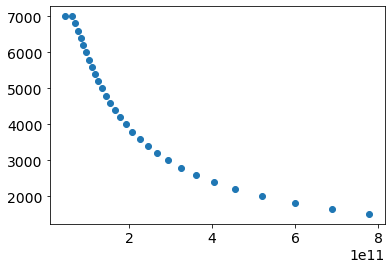

In [106]:
plt.plot(gaia17bpi_env.fuori.r_a[:30], gaia17bpi_env.fuori.temps[:30], 'o')

### Plotting data with model

In [107]:
model_wav = np.log10(wav*1e-4)
model_wav_flux =  np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2))

In [108]:
b, a = signal.butter(1, 0.35, 'low', analog=False)
filtered_signal = signal.filtfilt(b, a,  model_wav_flux)

In [109]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

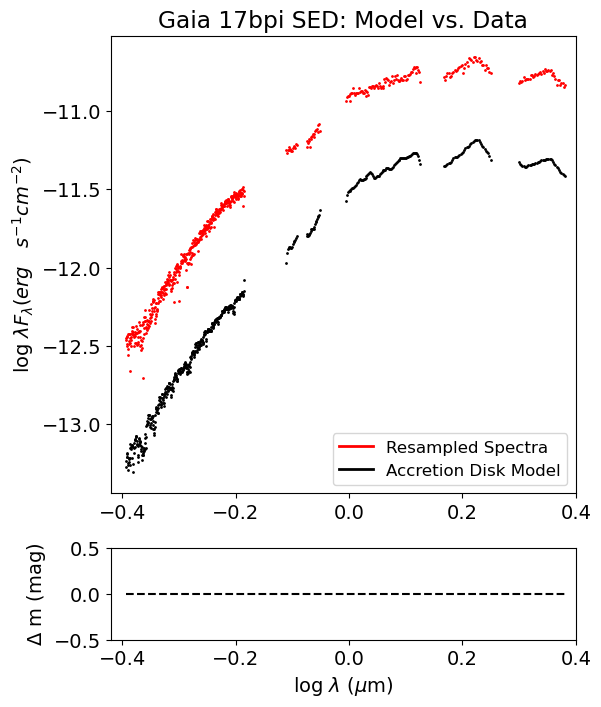

In [110]:
fig=plt.figure(figsize=(6, 8), dpi= 100)
gs = gridspec.GridSpec(2, 1,height_ratios=[5, 1])
plt.rcParams.update({'font.size': 14})

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


# plt.errorbar(WAV_DAT, FLUX_DAT, yerr=FLUX_DAT_ERR, marker='o', \
#              linestyle='', color='r', alpha=1, label='Palomar + IRTF \nResampled Spectra')

ax.plot(WAV_DAT, FLUX_DAT, 'ro', markersize=1, alpha=1, label='Resampled Spectra')
# ax.plot(model_wav,model_wav_flux, \
#          'ko', markersize = 1,  label='Stellar Atmospheres \n Acc. Disk (unsmoothed)')

ax.plot(model_wav, filtered_signal,'ko' , markersize = 1,  label='Stellar Atmospheres \n Acc. Disk (smoothed)')


# ax2.plot(model_wav, 100*(model_wav_flux - FLUX_DAT)/model_wav_flux, 'o', markersize=1)
# ax2.plot(model_wav, np.zeros(len(model_wav_flux)), 'k--')

ax2.plot(model_wav, (1/0.4)*np.log10((10**filtered_signal)/(10**FLUX_DAT)), 'ro', markersize=1)
ax2.plot(model_wav, np.zeros(len(model_wav_flux)), 'k--')


ax2.set_xlabel(r'log $\lambda$ ($\mu$m)')
ax2.set_ylabel(r'$\Delta$ m (mag)')
ax2.set_xlim(-0.5, 0.4)
ax2.set_ylim(-0.5,0.5)


ax2.set_xlabel(r'log $\lambda$ ($\mu$m)')
ax.set_ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
# ax2.set_ylabel(r'Percent Error')

ax.set_title('Gaia 17bpi SED: Model vs. Data')
# ax.set_ylim(-13, -10.5)
ax.set_xlim(-0.42, 0.4)
ax2.set_xlim(-0.42, 0.4)

legend_elements = [Line2D([0], [0], color='r', lw=2, label='Resampled Spectra'),
                   Line2D([0], [0], color='k', lw=2, label='Accretion Disk Model')]
ax.legend(handles=legend_elements, fontsize=12, loc='lower right')
# plt.savefig("sed_gaia17bpi_min_chisq.png", dpi=200, bbwox_inches='tight')
plt.show()

## MCMC Routine

In [111]:
def lnlike(theta, x, y, yerr):
    lacc, tmax, a_v, inc = theta
    const = (3/(8*np.pi*SIG_SB))*(1/7)*(36/49)**3
    lacc *= L_SUN
    m_star = 2*M_SUN
    r_star = (2*lacc*const/tmax**4)**0.5
    m_dot = 2*lacc*r_star/ G / m_star
    
    inc = np.degrees(np.arccos(inc))
#     inc =30
#     a_v = 3.52
    dist = 1270*3.08567758128e18
    pl_index = 0
    try:
    
        gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                              m_dot = m_dot, inc = inc, a_v = a_v, dist = dist, grav = 1.5, \
                                  direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index = pl_index)
    
    # Accounts for any random case where the model may not be generated properly given a certain combination
    # of parameters. This has only happened once, but it's presumably when the maximum temperature is too low.
    except:
        return 0
        
    
    # Converting units to properly compare model to data
    x_new = (10**x)*1e4
    modSpec = np.zeros(len(x_new))
    modSpec = gaia17bpi_env.fuori.mod_spec_lums
#     for i in range(len(x)):
#         modSpec[i] = gaia17bpi_env.getModSpecPoint(x[i], True)
    modSpec = pyasl.unred(x_new, modSpec, -a_v/3.1)
    flux = np.cos(np.radians(inc))*modSpec/(2*np.pi*(dist**2))
    

    model = np.log10(x_new*flux*1e-8)
    
    b, a = signal.butter(1, 0.35, 'low', analog=False)
    model = signal.filtfilt(b, a,  model)
    
    inv_sig = 1/yerr
    return np.sum(np.log((1/np.sqrt(2*np.pi))*inv_sig) - 0.5*((y - model)*inv_sig)**2)

In [112]:
L_ACC_LOW = 2
L_ACC_HIGH = 10

T_MAX_LOW = 4000
T_MAX_HIGH = 9000

A_V_LOW = 2
A_V_HIGH = 7

M_STAR_LOW = 0.1
M_STAR_HIGH = 2.0

In [113]:
def lnprior(theta):
    lacc, tmax, a_v, inc = theta
    if L_ACC_LOW < lacc < L_ACC_HIGH\
    and T_MAX_LOW < tmax < T_MAX_HIGH\
    and A_V_LOW < a_v < A_V_HIGH\
    and 0 < inc < 1:
        return 0.0
    return -np.inf

In [114]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + lnlike(theta, x, y, yerr))

In [115]:
ndim, nwalkers = 4, 16
lacc_start = 3.5
tmax_start = 7200
a_v_start = 3.5
m_star_start = -5
inc_start = 0.5

start = np.array((lacc_start, tmax_start, a_v_start, inc_start))
pos = [start + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [116]:
x = WAV_DAT
y_meas = FLUX_DAT
y_err = FLUX_DAT_ERR

In [117]:
len(WAV_DAT), len(gaia17bpi_env.fuori.mod_spec_lums)

(595, 595)

In [118]:
lnprob((lacc_start, tmax_start, a_v_start, inc_start), x,y_meas,y_err)

574.551373490717

In [119]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_meas, y_err))
%time sampler.run_mcmc(pos, 20000)

CPU times: user 19min 37s, sys: 5.72 s, total: 19min 42s
Wall time: 19min 46s


State([[6.45578948e+00 7.66409450e+03 3.54234302e+00 3.16975904e-01]
 [6.57728857e+00 8.04021250e+03 3.70810002e+00 3.32100708e-01]
 [8.27675931e+00 8.86647974e+03 3.94807705e+00 3.11302029e-01]
 [4.76429451e+00 8.97943257e+03 3.96812509e+00 5.40111522e-01]
 [4.81066983e+00 7.40649240e+03 3.39725213e+00 3.89297867e-01]
 [4.02423356e+00 7.96908608e+03 3.68364029e+00 5.47298909e-01]
 [3.75241694e+00 8.24856491e+03 3.76891713e+00 6.23869358e-01]
 [3.61736684e+00 7.54673863e+03 3.49239859e+00 5.41803369e-01]
 [5.80542963e+00 8.48798048e+03 3.79849298e+00 4.04730721e-01]
 [5.64989193e+00 7.72588750e+03 3.62200079e+00 3.71229384e-01]
 [4.04364767e+00 8.21044343e+03 3.68203945e+00 5.40875235e-01]
 [5.94237797e+00 7.12676083e+03 3.33772522e+00 3.05831192e-01]
 [5.58320933e+00 8.72372757e+03 3.84194160e+00 4.28191854e-01]
 [2.83623545e+00 8.73592267e+03 3.87686626e+00 8.69278069e-01]
 [2.39369428e+00 7.93313593e+03 3.68206079e+00 9.21266323e-01]
 [2.53496448e+00 8.97161527e+03 3.89652248e+00 9.

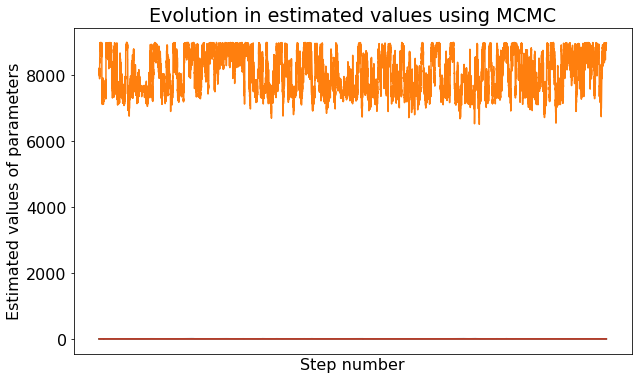

In [120]:
samples = sampler.chain[:, 10000:, :].reshape((-1, ndim))
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})

plt.plot(samples)
plt.xlabel('Step number')
plt.ylabel('Estimated values of parameters')
plt.title('Evolution in estimated values using MCMC')
plt.xticks([])
plt.show()

Quantiles:
[(0.16, 2.933411037044931), (0.5, 4.798880852140586), (0.84, 7.794658900408567)]
Quantiles:
[(0.16, 7458.257193830767), (0.5, 8004.963976261378), (0.84, 8813.485586070436)]
Quantiles:
[(0.16, 3.4603527065188286), (0.5, 3.668762969751196), (0.84, 3.875729136336089)]
Quantiles:
[(0.16, 0.28151577958585966), (0.5, 0.4475139550626463), (0.84, 0.7631371468767061)]


/Users/tonyrodriguez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


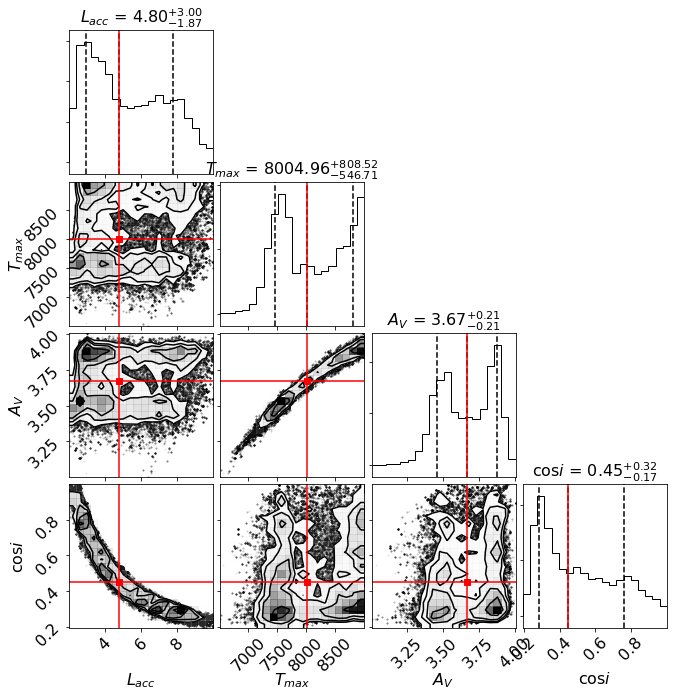

In [121]:
median_calcuated = np.median(samples, axis=0)

fig = corner.corner(samples, labels=[r'$L_{acc}$', r'$T_{max}$', r'$A_V$', r'$\cos i$'], verbose=True,
                       quantiles=(0.16, 0.5,0.84), plot_contours=True, scale_hist=True,
                       show_titles=True, title_kwargs={"fontsize": 16})

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(median_calcuated[i], color="r")
    
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(median_calcuated[xi], color="r")
        ax.axhline(median_calcuated[yi], color="r")
        ax.plot(median_calcuated[xi], median_calcuated[yi], "sr")

fig.show()
# fig.savefig("gaia17bpi_corner_lacc_select.png", dpi=180)

In [145]:
np.quantile(r_vals, .16)

0.3512732228178105

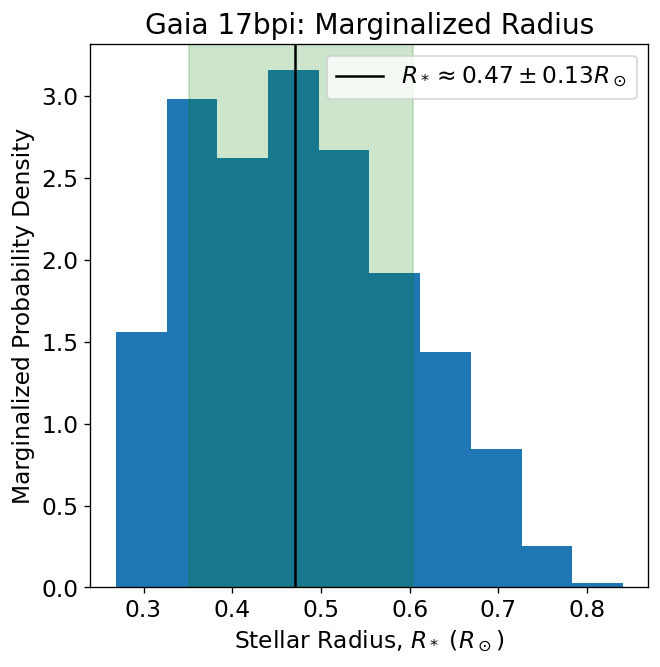

In [157]:
fig=plt.figure(figsize=(6, 6), dpi= 120)
plt.rcParams.update({'font.size': 14})
r_vals = getRadius(samples[:,0]*L_SUN, samples[:,1])/R_SUN

plt.title('Gaia 17bpi: Marginalized Radius')

diff_up = np.quantile(r_vals, .84) - np.quantile(r_vals, .50)
diff_down = np.quantile(r_vals, .50) - np.quantile(r_vals, .16)
med = np.quantile(r_vals, .50)

plt.hist(r_vals, density=True)
plt.axvline(med, color='k', \
            label=r'$R_* \approx {:.2f} \pm {:.2f} R_\odot$'.format(med, diff_up))                                                       
plt.axvspan(np.quantile(r_vals, .16), np.quantile(r_vals, .84),color='g', alpha=0.2)
plt.ylabel('Marginalized Probability Density')
plt.xlabel(r'Stellar Radius, $R_*$ ($R_\odot$)')
plt.legend()

# fig.savefig("gaia17bpi_hist_radius.png", dpi=180)
plt.show()

In [158]:
np.degrees(np.arccos(0.54))

57.31636115374206